In [1]:
%load_ext nb_black
%load_ext line_profiler

<IPython.core.display.Javascript object>

# Imports

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
from glob import glob
import math
import cvxpy as cp

start_time = datetime.datetime(2020, 12, 25, 0, 0, 0, 0)
# pd.read_csv(file).to_parquet('filename.parquet') # type, large, country

<IPython.core.display.Javascript object>

# States: Washington, Oregon, Idaho, Wyoming, Montana, N&S Dakota

## Magic Numbers and Abbreviation Finder

In [3]:
WASHINGTON = 53
OREGON = 41
IDAHO = 16
WYOMING = 56
MONTANA = 30
NORTHDAKOTA = 38
SOUTHDAKOTA = 46
SUPER = 50

<IPython.core.display.Javascript object>

## Read Files

In [4]:
# all_info = pd.read_parquet("Files/WY.parquet")
all_info = pd.read_parquet("temp.parquet")
ostate_code = (all_info["OFIPS"] / 1000).astype(int)
dstate_code = (all_info["DFIPS"] / 1000).astype(int)
all_info["OState"] = ostate_code
all_info["DState"] = dstate_code
all_info.head()

,County Code,Person ID,Trip Type,OType,OName,OFIPS,OLon,OLat,OXCoord,OYCoord,...,DType,DName,DFIPS,DLon,DLat,DXCoord,DYCoord,GCDistance,OState,DState
0,56003,56000040389,5,H,Home,56003,-108.561218,44.404587,-1094,1024,...,W,HASKELL FURNITURE & FLOORING,56003,-108.389359,44.836057,-1069,1084,31.021164,56,56
1,56003,56000040392,1,H,Home,56003,-108.561218,44.404587,-1094,1024,...,S,BURLINGTON ELEMENTARY,56003,-108.433746,44.451127,-1080,1030,7.071893,56,56
2,56003,56000040393,5,H,Home,56003,-108.561218,44.404587,-1094,1024,...,W,LOVELL MIDDLE SCHOOL,56003,-108.398331,44.830154,-1070,1083,30.509571,56,56
3,56003,56000040391,1,H,Home,56003,-108.561218,44.404587,-1094,1024,...,S,BURLINGTON MIDDLE SCHOOL,56003,-108.433748,44.451148,-1080,1030,7.072465,56,56
4,56003,56000040394,1,H,Home,56003,-108.561218,44.404587,-1094,1024,...,S,BURLINGTON ELEMENTARY,56003,-108.433746,44.451127,-1080,1030,7.071893,56,56


<IPython.core.display.Javascript object>

# 1. Assess the Rideshare-potential of each county in each state in your Region

## 1b. Use the process that was used in Homework 8 but now do it for each county in each state

In [5]:
def addLonLat(df, x, y, od):
    data = df.copy()
    if od == 1:
        data["oLat"] = 37 + 0.00722814 * (data[y] + 0.5)
        data["oLon"] = -97.5 + (
            0.00722814 * (data[x] + 0.5) / np.cos(np.radians(data.oLat))
        )
    elif od == 2:
        data["dLat"] = 37 + 0.00722814 * (data[y] + 0.5)
        data["dLon"] = -97.5 + (
            0.00722814 * (data[x] + 0.5) / np.cos(np.radians(data.dLat))
        )
    elif od == 3:
        data["Lat"] = 37 + 0.00722814 * ((data[y] * SUPER).astype(int) + 0.5)
        data["Lon"] = -97.5 + (
            0.00722814
            * ((data[x] * SUPER).astype(int) + 0.5)
            / np.cos(np.radians(data.Lat))
        )
    elif od == 4:
        data["oLat"] = 37 + 0.00722814 * ((data[y] * SUPER).astype(int) + 0.5)
        data["oLon"] = -97.5 + (
            0.00722814
            * ((data[x] * SUPER).astype(int) + 0.5)
            / np.cos(np.radians(data.oLat))
        )
    else:
        data["dLat"] = 37 + 0.00722814 * ((data[y] * SUPER).astype(int) + 0.5)
        data["dLon"] = -97.5 + (
            0.00722814
            * ((data[x] * SUPER).astype(int) + 0.5)
            / np.cos(np.radians(data.dLat))
        )
    return data

<IPython.core.display.Javascript object>

### 1.b.1. Keep a running count of personTrips for each Pixel, County and State: (files (tables)... **pTripsP: {xPixel, yPixel, count}**, **pTripsC: {CountyFIPS, count}**, **pTripsS: {StateFIPS, count}**

In [6]:
# Region_pTrips
pTripsPO = addLonLat(
    all_info.groupby(["OXCoord", "OYCoord"]).size().reset_index(name="count"),
    "OXCoord",
    "OYCoord",
    1,
)
pTripsPD = addLonLat(
    all_info.groupby(["DXCoord", "DYCoord"]).size().reset_index(name="count"),
    "DXCoord",
    "DYCoord",
    2,
)
pTripsC = all_info.groupby(["OFIPS"]).size().reset_index(name="count")
pTripsSO = all_info.groupby(["OState"]).size().reset_index(name="count")
pTripsSD = all_info.groupby(["DState"]).size().reset_index(name="count")
pTripsOName = all_info.groupby(["OName"]).size().reset_index(name="count")
pTripsDName = all_info.groupby(["DName"]).size().reset_index(name="count")

pTripsPO.to_csv("Outputs/Region_pTripsPO.csv")
pTripsPD.to_csv("Outputs/Region_pTripsPD.csv")
pTripsC.to_csv("Outputs/Region_pTripsC.csv")
pTripsSO.to_csv("Outputs/Region_pTripsSO.csv")
pTripsSD.to_csv("Outputs/Region_pTripsSD.csv")
pTripsOName.to_csv("Outputs/Region_pTripsOName.csv")
pTripsDName.to_csv("Outputs/Region_pTripsDName.csv")

print("number of person trips:", len(all_info))

number of person trips: 48876


<IPython.core.display.Javascript object>

### 1.b.2. If GCD < 0.707 it is assigned to walking, just keep a running count for each Pixel, County and State: (files (tables)... **WalkP: {xPixel, yPixel, count}**, **WalkC: {CountyFIPS, count}**, **WalkS: {StateFIPS, count}**

In [7]:
# RegionWalk
walk = all_info.loc[all_info.GCDistance < 0.707]

walkP = addLonLat(
    walk.groupby(["OXCoord", "OYCoord"]).size().reset_index(name="count"),
    "OXCoord",
    "OYCoord",
    1,
)
walkC = walk.groupby(["OFIPS"]).size().reset_index(name="count")
walkS = walk.groupby(["OState"]).size().reset_index(name="count")

walkP.to_csv("Outputs/Region_walkP.csv")
walkC.to_csv("Outputs/Region_walkC.csv")
walkS.to_csv("Outputs/Region_walkS.csv")

print("number of walking trips:", len(walk))

number of walking trips: 12252


<IPython.core.display.Javascript object>

### 1.b.3. If 0.707 <= GCD< 350 it is shared aTaxi trip as per our LoS(GCD<3 miles, then one of 4 directional Slices with a DD of 300 seconds, else one of 8 directional Slices with DD = 450 Seconds. MaxOccupancy = 6.)
#### 1.b.3.a. Write each departed vehicleTrip to a file **Region_oFIPS_vehicleTrip: {oFIPS, oXpixel, oYpixel, oTime, dXpixel, dYpixel, DepartingOccupancy, SumCartesianPersonTripMiles, CartesianVehicleMiles}**

In [8]:
def compute_destination(df):
    gcd = df.GCDistance.copy()  # gcd
    cum = df.index.to_series() + 1  # cumulative #
    original_row_order = df.index.to_series() + 1
    oTimeHour = df.ODepartureTime.copy() / 3600  # oTimeHour
    cumOfPersonTrips = cum / len(df)  # cumulative prob
    walk_aTaxi = pd.Series(["Walk" if x < 0.707 else "aTaxi" for x in df["GCDistance"]])

    delX = df.DXCoord - df.OXCoord
    delY = df.DYCoord - df.OYCoord

    ox = df.OXCoord.copy()
    oy = df.OYCoord.copy()
    dx = df.DXCoord.copy()
    dy = df.DYCoord.copy()

    ostate = df.OState.copy()
    dstate = df.DState.copy()
    oFIPS = df.OFIPS.copy()
    dFIPS = df.DFIPS.copy()

    oDepartureTime = df.ODepartureTime.copy()
    atan2 = np.degrees(np.arctan2(delX + 0.00001, delY))
    trip_heading_deg = pd.Series([x + 360 if x < 0 else x for x in atan2])
    slices_10 = (trip_heading_deg / 36).astype(int)

    # destination zone
    destination_zone = []
    for i, row in df.iterrows():
        if row["GCDistance"] < 0.707:
            destination_zone.append(0)
        elif row["GCDistance"] >= 0.707 and row["GCDistance"] < 3:
            destination_zone.append(int(trip_heading_deg[i] / 90) + 1)  # .astype(int)
        elif row["GCDistance"] >= 3 and row["GCDistance"] < 100:
            destination_zone.append(int(trip_heading_deg[i] / 45) + 5)
        else:  # >= 100
            destination_zone.append(int(trip_heading_deg[i] / 45) + 13)
    info = pd.DataFrame(
        {
            "Original Row Order": original_row_order,
            "OState": ostate,
            "OFIPS": oFIPS,
            "OXCoord": ox,
            "OYCoord": oy,
            "ODepartureTime": oDepartureTime,
            "DState": dstate,
            "DFIPS": dFIPS,
            "DXCoord": dx,
            "DYCoord": dy,
            "Destination Zone": destination_zone,
            "GCDistance": gcd,
        }
    )
    return info

<IPython.core.display.Javascript object>

In [9]:
def sort1(calc):
    original_row_order = calc["Original Row Order"].copy()
    ostate = calc.OState.copy()
    dstate = calc.DState.copy()
    oFIPS = calc.OFIPS.copy()
    dFIPS = calc.DFIPS.copy()
    oxcoord = calc.OXCoord.copy()
    oycoord = calc.OYCoord.copy()
    oDepartureTime = calc.ODepartureTime.copy()
    dxcoord = calc.DXCoord.copy()
    dycoord = calc.DYCoord.copy()
    gcd = calc.GCDistance.copy()
    destination_zone = calc["Destination Zone"].copy()

    sort1 = pd.DataFrame(
        {
            "Original Row Order": original_row_order,
            "OState": ostate,
            "OFIPS": oFIPS,
            "OXCoord": oxcoord,
            "OYCoord": oycoord,
            "ODepartureTime": oDepartureTime,
            "DState": dstate,
            "DFIPS": dFIPS,
            "DXCoord": dxcoord,
            "DYCoord": dycoord,
            "GCDistance": gcd,
            "Destination Zone": destination_zone,
        }
    )
    sort1 = sort1.sort_values(
        by=["OXCoord", "OYCoord", "Destination Zone", "ODepartureTime"], ascending=True
    )
    sort1 = sort1.reset_index(drop=True)
    return sort1

<IPython.core.display.Javascript object>

In [10]:
def assign_taxis(df):
    original_row_order = df["Original Row Order"].copy()
    departure = df["ODepartureTime"].copy()
    destination = df["Destination Zone"].copy()
    gcd = df["GCDistance"].copy()
    # aTaxi departure time, aTaxi departure #
    aTaxi_departure_time = []
    aTaxi_departure_number = []
    prev_destination_zone = 0
    vehicle_occupancy = 0
    for i, row in df.iterrows():
        if row["Destination Zone"] != 0 and i != 0:
            if (
                row["Destination Zone"] == prev_destination_zone
            ):  # same destination zone
                if (row["ODepartureTime"] < aTaxi_departure_time[-1]) and (
                    vehicle_occupancy < 6
                ):
                    aTaxi_departure_time.append(aTaxi_departure_time[-1])
                    aTaxi_departure_number.append(aTaxi_departure_number[-1])
                    vehicle_occupancy += 1
                else:
                    if row["GCDistance"] < 3:  # if gcd < 3, can wait 5 min
                        aTaxi_departure_time.append(row["ODepartureTime"] + 300)
                    elif (
                        row["GCDistance"] >= 3 and row["GCDistance"] < 100
                    ):  # if 3 <= gcd < 100, can wait 7.5 min
                        aTaxi_departure_time.append(row["ODepartureTime"] + 450)
                    else:  # if gcd > 100, can wait 15 min
                        aTaxi_departure_time.append(row["ODepartureTime"] + 900)
                    aTaxi_departure_number.append(aTaxi_departure_number[-1] + 1)
                    vehicle_occupancy = 1
            else:  # different destination zone
                if gcd[i] < 3:  # if gcd < 3, can wait 5 min
                    aTaxi_departure_time.append(row["ODepartureTime"] + 300)
                elif (
                    gcd[i] >= 3 and gcd[i] < 100
                ):  # if 3 <= gcd < 100, can wait 7.5 min
                    aTaxi_departure_time.append(row["ODepartureTime"] + 450)
                else:  # if gcd > 100, can wait 15 min
                    aTaxi_departure_time.append(row["ODepartureTime"] + 900)
                aTaxi_departure_number.append(aTaxi_departure_number[-1] + 1)
        else:
            aTaxi_departure_time.append(0)
            aTaxi_departure_number.append(0)
        prev_destination_zone = row["Destination Zone"]

    # customer number
    customer_number = []
    customer_number.append(1)
    for i in range(1, len(df.index)):
        if aTaxi_departure_number[i] == aTaxi_departure_number[i - 1]:
            customer_number.append(customer_number[i - 1] + 1)
        else:
            customer_number.append(1)
    # x, y origination/destination coordinates
    customer_oXPixel = df.OXCoord.copy()
    customer_oYPixel = df.OYCoord.copy()
    customer_dXPixel = df.DXCoord.copy()
    customer_dYPixel = df.DYCoord.copy()
    # OFIPS
    oFIPS = df.OFIPS.copy()
    ostate = df.OState.copy()
    dFIPS = df.DFIPS.copy()
    dstate = df.DState.copy()
    assign = pd.DataFrame(
        {
            "Original Row Order": original_row_order,
            "aTaxi Departure #": aTaxi_departure_number,
            "aTaxi Departure Time": aTaxi_departure_time,
            "Customer Departure Time": departure,
            "Customer # in aTaxi": customer_number,
            "OState": ostate,
            "OFIPS": oFIPS,
            "oXPixel": customer_oXPixel,
            "oYPixel": customer_oYPixel,
            "DState": ostate,
            "DFIPS": dFIPS,
            "dXPixel": customer_dXPixel,
            "dYPixel": customer_dYPixel,
            "GCDistance": gcd,
            "Destination Zone": destination,
        }
    )
    return assign

<IPython.core.display.Javascript object>

In [11]:
def sort2(assign):
    original_row_order = assign["Original Row Order"].copy()
    aTaxi_departure_num = assign["aTaxi Departure #"].copy()
    aTaxi_departure_time = assign["aTaxi Departure Time"].copy()
    customer_departure_time = assign["Customer Departure Time"].copy()
    customer_num = assign["Customer # in aTaxi"].copy()
    ostate = assign["OState"].copy()
    oFIPS = assign["OFIPS"].copy()
    dstate = assign["DState"].copy()
    dFIPS = assign["DFIPS"].copy()
    customer_oXPixel = assign["oXPixel"].copy()
    customer_oYPixel = assign["oYPixel"].copy()
    customer_dXPixel = assign["dXPixel"].copy()
    customer_dYPixel = assign["dYPixel"].copy()
    gcd = assign["GCDistance"].copy()
    pixel_distance = 0.5 * np.sqrt(
        (customer_dXPixel - customer_oXPixel) ** 2
        + (customer_dYPixel - customer_oYPixel) ** 2
    )

    destination_zone = assign["Destination Zone"].copy()

    sort2 = pd.DataFrame(
        {
            "Original Row Order": original_row_order,
            "aTaxi Departure #": aTaxi_departure_num,
            "aTaxi Departure Time": aTaxi_departure_time,
            "Customer Departure Time": customer_departure_time,
            "Customer # in aTaxi": customer_num,
            "OState": ostate,
            "OFIPS": oFIPS,
            "oXPixel": customer_oXPixel,
            "oYPixel": customer_oYPixel,
            "DState": dstate,
            "DFIPS": dFIPS,
            "dXPixel": customer_dXPixel,
            "dYPixel": customer_dYPixel,
            "GCDistance": gcd,
            "Pixel Distance": pixel_distance,
            "Destination Zone": destination_zone,
        }
    )
    sort2 = sort2.sort_values(
        by=["aTaxi Departure #", "Pixel Distance", "dXPixel", "dYPixel"], ascending=True
    )
    sort2 = sort2.reset_index(drop=True)
    return sort2

<IPython.core.display.Javascript object>

In [12]:
def calc_distance(o, d):
    return 0.5 * np.sqrt((d[0] - o[0]) ** 2 + (d[1] - o[1]) ** 2)

<IPython.core.display.Javascript object>

In [13]:
def num_passengers(group):
    return len(group)


def sum_person_miles(group):
    return group["Pixel Distance"].sum()


def avg_wait_time(group):
    return (group["aTaxi Departure Time"] - group["Customer Departure Time"]).mean()


def ataxi_miles(group):
    time = group["aTaxi Departure Time"].iloc[0]
    # walking gang
    if group["aTaxi Departure #"].iloc[0] == 0:
        return float("nan"), float("nan"), float("nan"), float("nan"), float("nan")
    else:
        start_location = (group["oXPixel"].iloc[0], group["oYPixel"].iloc[0])
        destinations = list(group.groupby(["dXPixel", "dYPixel"]).groups.keys())

        distance_traveled = 0
        current_location = start_location

        # Greedy method
        while len(destinations) > 0:
            distances = [
                calc_distance(current_location, destination)
                for destination in destinations
            ]
            min_distance = min(distances)
            idx_min = distances.index(min_distance)

            distance_traveled += distances[idx_min]
            current_location = destinations[idx_min]
            if min_distance < 40:
                time += min_distance / 30 * 3600
            else:
                time += min_distance / 60 * 3600

            destinations.pop(idx_min)

        distance_start_to_finish = calc_distance(current_location, start_location)
        circuity = (distance_traveled / distance_start_to_finish) - 1

        return (
            distance_traveled,
            current_location[0],
            current_location[1],
            circuity,
            time.astype(int),
        )


def departure_time(group):
    return group["aTaxi Departure Time"].iloc[0]


def aggregating_functions(group):
    data = {}
    data["aTaxi Departure Occupancy"] = num_passengers(group)
    data["Sum Person Miles"] = sum_person_miles(group)
    (
        data["Sum aTaxi Miles"],
        data["dXPixel"],
        data["dYPixel"],
        data["Circuity"],
        data["aTaxi Arrival Time"],
    ) = ataxi_miles(group)
    data["AVO"] = data["Sum Person Miles"] / data["Sum aTaxi Miles"]
    data["ADO"] = (
        (data["aTaxi Arrival Time"] - departure_time(group))
        * data["aTaxi Departure Occupancy"]
    ) / 1440
    data["Average Wait Time"] = avg_wait_time(group)
    return pd.Series(data)


def final(df):
    data = df.groupby(
        [
            "aTaxi Departure #",
            "OState",
            "OFIPS",
            "oXPixel",
            "oYPixel",
            "aTaxi Departure Time",
            "Destination Zone",
        ]
    ).apply(aggregating_functions)
    data = data.reset_index()
    return data.dropna()

<IPython.core.display.Javascript object>

In [14]:
# Region_oFIPS_vehicleTrip: {oFIPS, oXpixel, oYpixel, oTime, dXpixel, dYpixel, DepartingOccupancy,
# SumCartesianPersonTripMiles, CartesianVehicleMiles}

taxi = all_info.loc[((all_info.GCDistance >= 0.707) & (all_info.GCDistance < 350))]
taxi = taxi.sort_values(
    by=["GCDistance", "ODepartureTime"], ascending=True
).reset_index(drop=True)
calc = compute_destination(taxi)  # compute destination zones
sort1 = sort1(calc)  # sort by ox, oy, destination zone & departure time
assign = assign_taxis(sort1)  # assign taxis
sort2 = sort2(assign)  # sort by departure #, pixel distance, dx, dy
vehicle_trip = final(sort2)  # final data
vehicle_trip.head(10)

,aTaxi Departure #,OState,OFIPS,oXPixel,oYPixel,aTaxi Departure Time,Destination Zone,aTaxi Departure Occupancy,Sum Person Miles,Sum aTaxi Miles,dXPixel,dYPixel,Circuity,aTaxi Arrival Time,AVO,ADO,Average Wait Time
1,1,16,16003,-1892,1093,40449.0,7,1.0,12.349089,12.349089,-1871.0,1080.0,0.0,41930.0,1.0,1.028472,450.0
2,2,16,16003,-1892,1093,75692.0,7,1.0,19.006578,19.006578,-1861.0,1071.0,0.0,77972.0,1.0,1.583333,450.0
3,3,16,16003,-1892,1093,25565.0,9,1.0,48.846699,48.846699,-1930.0,1003.0,0.0,28495.0,1.0,2.034722,450.0
4,4,16,16003,-1889,1110,57658.0,7,1.0,24.253866,24.253866,-1841.0,1103.0,0.0,60568.0,1.0,2.020833,450.0
5,5,16,16003,-1889,1110,19040.0,8,1.0,24.129857,24.129857,-1862.0,1070.0,0.0,21935.0,1.0,2.010417,450.0
6,6,16,16003,-1889,1110,24785.0,8,1.0,24.964975,24.964975,-1862.0,1068.0,0.0,27780.0,1.0,2.079861,450.0
7,7,16,16003,-1889,1110,25910.0,8,2.0,49.929951,24.964975,-1862.0,1068.0,0.0,28905.0,2.0,4.159722,437.0
8,8,16,16003,-1889,1110,38577.0,8,1.0,24.005208,24.005208,-1861.0,1071.0,0.0,41457.0,1.0,2.000000,450.0
9,9,16,16003,-1888,1088,28652.0,7,1.0,16.101242,16.101242,-1862.0,1069.0,0.0,30584.0,1.0,1.341667,450.0
10,10,16,16003,-1880,1054,26036.0,5,1.0,13.756816,13.756816,-1871.0,1080.0,0.0,27686.0,1.0,1.145833,450.0


<IPython.core.display.Javascript object>

## Save Files

In [16]:
# Region_oFIPS_vehicleTrip
vehicle_trip.to_csv("Outputs/Region_oFIPS_vehicleTrip.csv")
vehicle_trip_temp = addLonLat(vehicle_trip, "oXPixel", "oYPixel", 1)
vehicle_trip_izzy = addLonLat(vehicle_trip_temp, "dXPixel", "dYPixel", 2)
vehicle_trip_izzy.to_csv("Outputs/Region_oFIPS_vehicleTrip_Isabelle.csv")

<IPython.core.display.Javascript object>

## **FOR ISABELLE**: (origin & destination frequency for **Region_oFIPS_vehicleTrip**, cdf of person trip length, vehicle trip length)

In [91]:
def generate_cdf(df, column):
    chart = df.copy()
    chart = chart.groupby(column).size().reset_index(name="Frequency")
    chart["PDF"] = chart["Frequency"] / sum(chart["Frequency"])
    chart["CDF"] = chart["PDF"].cumsum()
    return chart[[column, "Frequency", "CDF"]]

<IPython.core.display.Javascript object>

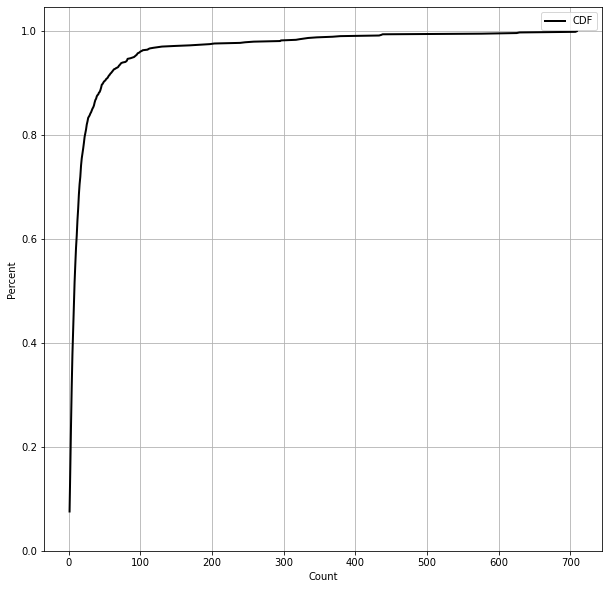

<IPython.core.display.Javascript object>

In [18]:
# Region_vTrips
vTripsO = addLonLat(
    vehicle_trip.groupby(["oXPixel", "oYPixel"]).size().reset_index(name="count"),
    "oXPixel",
    "oYPixel",
    1,
)
vTripsO.to_csv("Outputs/Region_vTripsO.csv")
vTripsO.rename({"count": "Count"}, axis=1, inplace=True)
cdf_vTripsO = generate_cdf(vTripsO, "Count")
cdf_vTripsO_plt = cdf_vTripsO.plot(
    x="Count",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Black",
    lw=2,
    ylabel="Percent",
)
cdf_vTripsO_plt.set_ylim(ymin=0)
cdf_vTripsO_plt.get_figure().savefig("Outputs/cdf_vTripsO_plt.png")


vTripsD = addLonLat(
    vehicle_trip.groupby(["dXPixel", "dYPixel"]).size().reset_index(name="count"),
    "dXPixel",
    "dYPixel",
    2,
)

vTripsD.to_csv("Outputs/Region_vTripsD.csv")

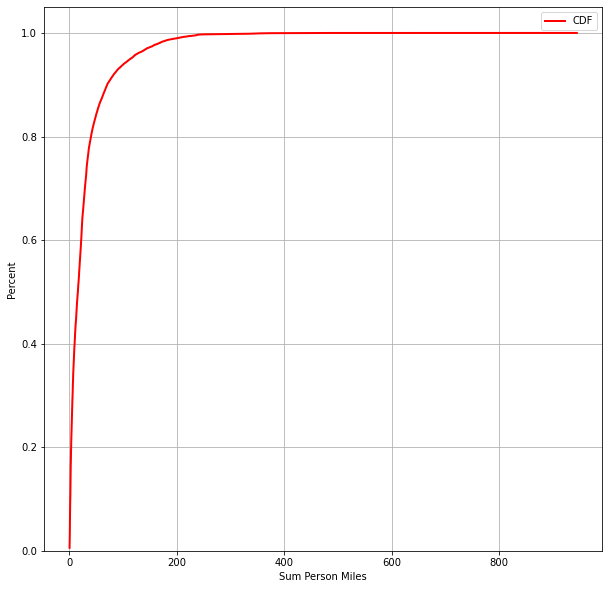

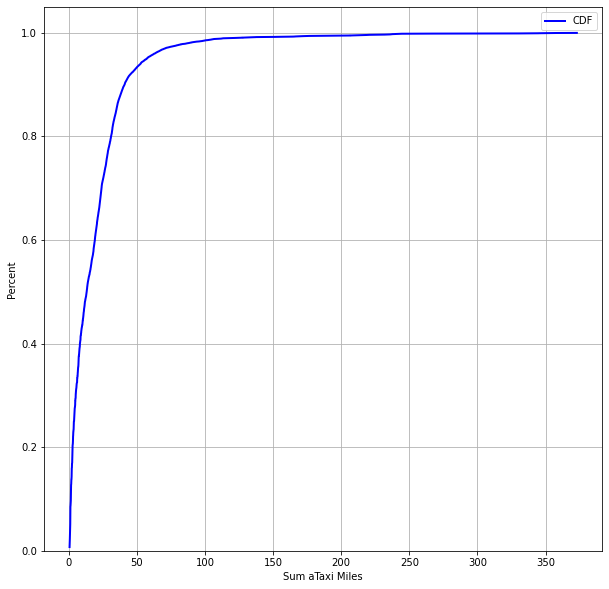

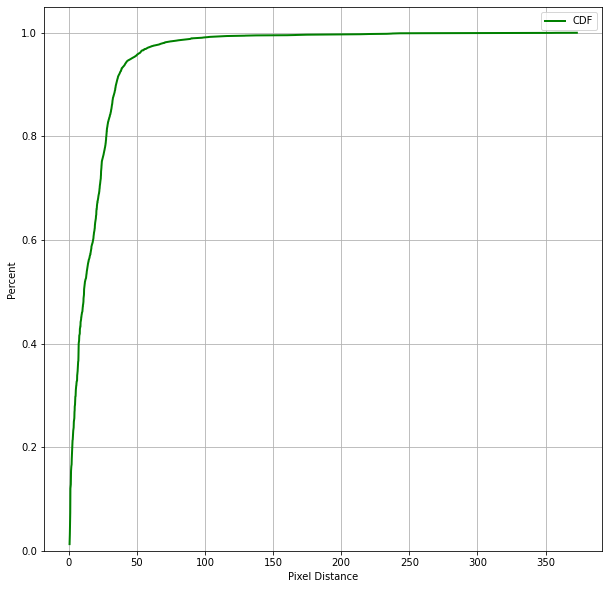

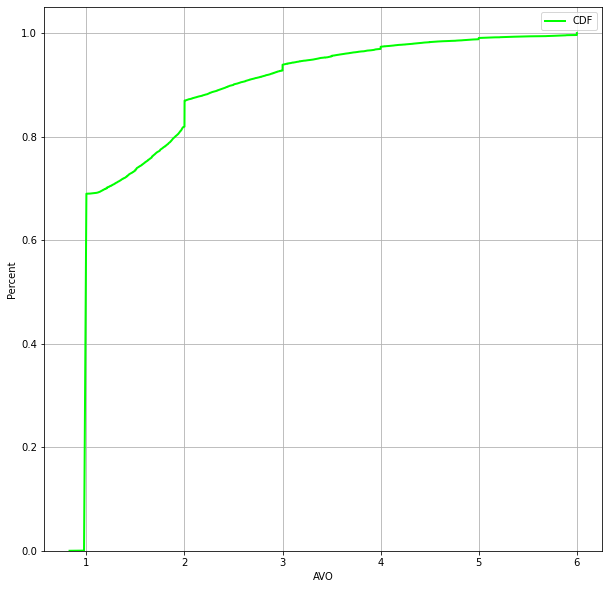

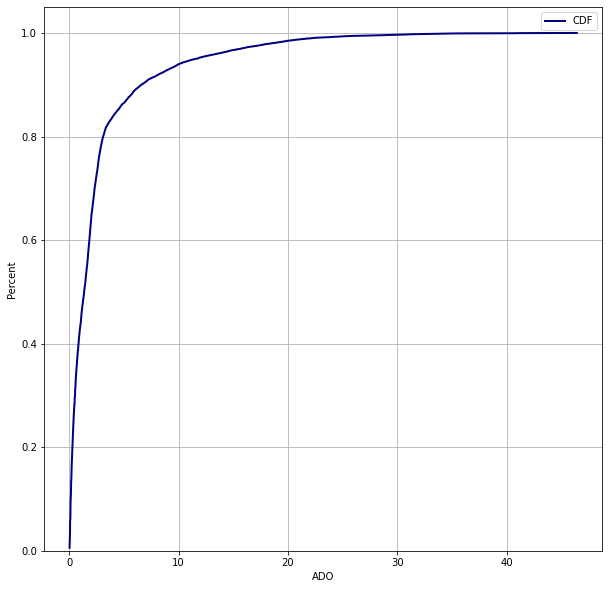

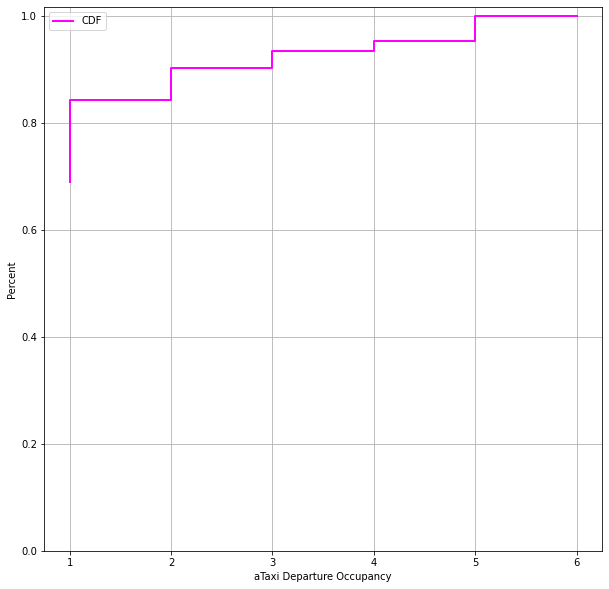

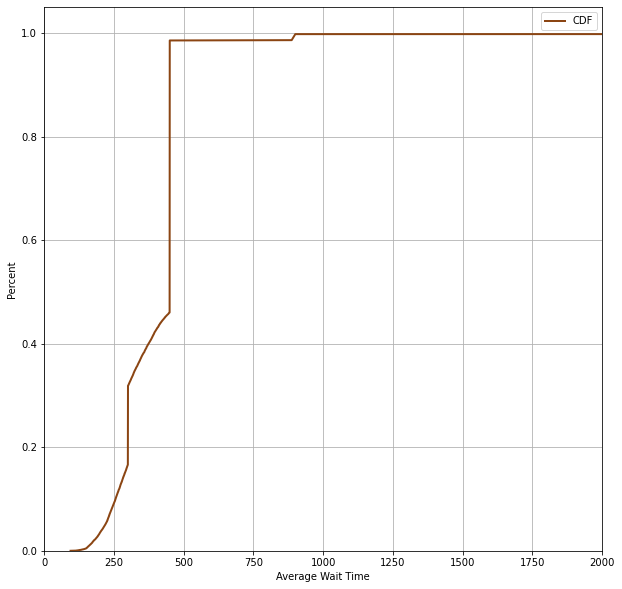

<IPython.core.display.Javascript object>

In [98]:
cdf_SPM = generate_cdf(vehicle_trip, "Sum Person Miles")
cdf_SAM = generate_cdf(vehicle_trip, "Sum aTaxi Miles")
cdf_pixelDistance = generate_cdf(sort2, "Pixel Distance")
cdf_AVO = generate_cdf(vehicle_trip, "AVO")
cdf_ADO = generate_cdf(vehicle_trip, "ADO")
cdf_averageDepartureOccupancy = generate_cdf(vehicle_trip, "aTaxi Departure Occupancy")
cdf_averageWaitTime = generate_cdf(vehicle_trip, "Average Wait Time")

cdf_SPM_plt = cdf_SPM.plot(
    x="Sum Person Miles",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Red",
    lw=2,
    ylabel="Percent",
)
cdf_SPM_plt.set_ylim(ymin=0)
cdf_SPM_plt.get_figure().savefig("Outputs/cdf_SPM_plt.png")
cdf_SAM_plt = cdf_SAM.plot(
    x="Sum aTaxi Miles",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Blue",
    lw=2,
    ylabel="Percent",
)
cdf_SAM_plt.set_ylim(ymin=0)
cdf_SAM_plt.get_figure().savefig("Outputs/cdf_SAM_plt.png")
cdf_pixelDistance_plt = cdf_pixelDistance.plot(
    x="Pixel Distance",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Green",
    lw=2,
    ylabel="Percent",
)
cdf_pixelDistance_plt.set_ylim(ymin=0)
cdf_pixelDistance_plt.get_figure().savefig("Outputs/cdf_pixelDistance_plt.png")
cdf_AVO_plt = cdf_AVO.plot(
    x="AVO",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Lime",
    lw=2,
    ylabel="Percent",
)
cdf_AVO_plt.set_ylim(ymin=0)
cdf_AVO_plt.get_figure().savefig("Outputs/cdf_AVO_plt.png")
cdf_ADO_plt = cdf_ADO.plot(
    x="ADO",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Navy",
    lw=2,
    ylabel="Percent",
)
cdf_ADO_plt.set_ylim(ymin=0)
cdf_ADO_plt.get_figure().savefig("Outputs/cdf_ADO_plt.png")
cdf_averageDepartureOccupancy_plt = cdf_averageDepartureOccupancy.plot(
    x="aTaxi Departure Occupancy",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Magenta",
    lw=2,
    drawstyle="steps",
    ylabel="Percent",
)
cdf_averageDepartureOccupancy_plt.set_ylim(ymin=0)
cdf_averageDepartureOccupancy_plt.get_figure().savefig(
    "Outputs/cdf_averageDepartureOccupancy_plt.png"
)
cdf_averageWaitTime_plt = cdf_averageWaitTime.plot(
    x="Average Wait Time",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Saddlebrown",
    lw=2,
    ylabel="Percent",
)
cdf_averageWaitTime_plt.set_ylim(ymin=0)
cdf_averageWaitTime_plt.set_xlim(xmin=0, xmax=2000)
cdf_averageWaitTime_plt.get_figure().savefig("Outputs/cdf_averageWaitTime_plt.png")

### 1.b.4. Create Summary Stats for each Pixel, County and State 

In [21]:
def person_trip_ct(group):
    return group["aTaxi Departure Occupancy"].sum()


def vehicle_trip_ct1(group):
    return len(group)


def sum_person_miles(group):
    return group["Sum Person Miles"].sum()


def sum_vehicle_miles(group):
    return group["Sum aTaxi Miles"].sum()


def avo(group):
    return group["AVO"].mean()


def ado(group):
    return group["ADO"].mean()


def average_departure_occupancy(group):
    return group["aTaxi Departure Occupancy"].mean()


def summary_functions(group):
    data = {}
    data["Person Trip Count"] = person_trip_ct(group)
    data["Vehicle Trip Count"] = vehicle_trip_ct1(group)
    data["Person Trip Miles"] = sum_person_miles(group)
    data["Vehicle Trip Miles"] = sum_vehicle_miles(group)
    data["Average Person Trip Length"] = sum_person_miles(group) / person_trip_ct(group)
    data["Average Vehicle Trip Length"] = sum_vehicle_miles(group) / vehicle_trip_ct1(
        group
    )
    data["Average AVO"] = avo(group)
    data["Average ADO"] = ado(group)
    data["Average Departure Occupancy"] = average_departure_occupancy(group)
    return pd.Series(data)

<IPython.core.display.Javascript object>

#### 1.b.4.a. **aTaxiP: {xPixel, yPixel, personTripCount, vehicleTripCount, personTripMiles, vehicleTripMiles, averagePersonTripLength}**

In [22]:
aTaxiP = addLonLat(
    vehicle_trip.groupby(["oXPixel", "oYPixel"]).apply(summary_functions).reset_index(),
    "oXPixel",
    "oYPixel",
    1,
)
print("number of pixels served:", len(aTaxiP))
aTaxiP.to_csv("Outputs/Region_aTaxiP.csv")

number of pixels served: 846


<IPython.core.display.Javascript object>

#### 1.b.4.b. **aTaxiC: {CountyFIPS, personTripCount, vehicleTripCount, personTripMiles, vehicleTripMiles }**

In [23]:
aTaxiC = vehicle_trip.groupby(["OFIPS"]).apply(summary_functions).reset_index()
print("number of counties served:", len(aTaxiC))
aTaxiC.to_csv("Outputs/Region_aTaxiC.csv")

number of counties served: 3


<IPython.core.display.Javascript object>

#### 1.b.4.c. **aTaxiS: {StateFIPS, personTripCount, vehicleTripCount, personTripMiles, vehicleTripMiles}**

In [24]:
aTaxiS = vehicle_trip.groupby(["OState"]).apply(summary_functions).reset_index()
print("number of counties served:", len(aTaxiS))
aTaxiS.to_csv("Outputs/Region_aTaxiS.csv")

number of counties served: 2


<IPython.core.display.Javascript object>

## **FOR ISABELLE**: info about min, max, mean, sd for Person Trip Count, Vehicle Trip Count, Avg Person Trip Length, Avg Vehicle Trip [only want that at the county level]


In [25]:
def get_info(df, column):
    col = np.array(df[[column]])
    min = np.min(col)
    max = np.max(col)
    mean = np.mean(col)
    sd = np.std(col)
    return min, max, mean, sd

<IPython.core.display.Javascript object>

In [26]:
# Region_aTaxiAvg
PTCmin, PTCmax, PTCmean, PTCsd = get_info(aTaxiC, "Person Trip Count")
VTCmin, VTCmax, VTCmean, VTCsd = get_info(aTaxiC, "Vehicle Trip Count")
aPTLmin, aPTLmax, aPTLmean, aPTLsd = get_info(aTaxiC, "Average Person Trip Length")
aVTLmin, aVTLmax, aVTLmean, aVTLsd = get_info(aTaxiC, "Average Vehicle Trip Length")

print("Person Trip Count")
print("min:", PTCmin)
print("max:", PTCmax)
print("mean:", PTCmean)
print("sd:", PTCsd)

print("\nVehicle Trip Count")
print("min:", VTCmin)
print("max:", VTCmax)
print("mean:", VTCmean)
print("sd:", VTCsd)

print("\nAverage Person Trip Length")
print("min:", aPTLmin)
print("max:", aPTLmax)
print("mean:", aPTLmean)
print("sd:", aPTLsd)

print("\nAverage Vehicle Trip Length")
print("min:", aVTLmin)
print("max:", aVTLmax)
print("mean:", aVTLmean)
print("sd:", aVTLsd)

Person Trip Count
min: 6.0
max: 27054.0
mean: 12179.666666666666
sd: 11206.211858706858

Vehicle Trip Count
min: 6.0
max: 15884.0
mean: 7251.0
sd: 6556.047030541092

Average Person Trip Length
min: 13.943654287912082
max: 26.440068550926394
mean: 19.58443350037734
sd: 5.173457798462688

Average Vehicle Trip Length
min: 15.772195683315756
max: 26.440068550926394
mean: 21.20001504609314
sd: 4.357164207213443


<IPython.core.display.Javascript object>

### 1.b.5. If GCD > 350 miles

In [27]:
plane = all_info.loc[all_info.GCDistance >= 350]
print("number of airport trips:", len(plane))

number of airport trips: 84


<IPython.core.display.Javascript object>

#### 1.b.5.b for each State airportTripStateFIPS: {oXpixel, oYpixel, oTime}

In [28]:
def find_plane_trips(df, state):
    state_trips = df.loc[df["OFIPS"] == state].copy()
    return state_trips[
        [
            "OFIPS",
            "OXCoord",
            "OYCoord",
            "OLon",
            "OLat",
            "ODepartureTime",
            "OName",
            "DFIPS",
            "DXCoord",
            "DYCoord",
            "DLon",
            "DLat",
            "DName",
        ]
    ]

<IPython.core.display.Javascript object>

In [29]:
airport_trips_WA = find_plane_trips(plane, WASHINGTON)
airport_trips_OR = find_plane_trips(plane, OREGON)
airport_trips_ID = find_plane_trips(plane, IDAHO)
airport_trips_WY = find_plane_trips(plane, WYOMING)
airport_trips_MT = find_plane_trips(plane, MONTANA)
airport_trips_ND = find_plane_trips(plane, NORTHDAKOTA)
airport_trips_SD = find_plane_trips(plane, SOUTHDAKOTA)

<IPython.core.display.Javascript object>

## Save Files

In [30]:
airport_trips_WA.to_csv("Outputs/WA_airportTripStateFIPS")
airport_trips_OR.to_csv("Outputs/OR_airportTripStateFIPS")
airport_trips_ID.to_csv("Outputs/ID_airportTripStateFIPS")
airport_trips_WY.to_csv("Outputs/WY_airportTripStateFIPS")
airport_trips_MT.to_csv("Outputs/MT_airportTripStateFIPS")
airport_trips_ND.to_csv("Outputs/ND_airportTripStateFIPS")
airport_trips_SD.to_csv("Outputs/SD_airportTripStateFIPS")

<IPython.core.display.Javascript object>

# 2. Assess Fleet size Requirements for your Region


## 2.a. Estimate our maxFleetSize for each region based on a Hierarchical Vehicle Management Strategy where we will maintain our fleet at a strategicPixel within each 10x10 SuperPixels throughout our region.

### 2.a.i. We will size our fleet to be 10% greater than the minimumFleetSize for our region.
### 2.a.i.1. Using your **Region_oFIPS_vehicleTrip{}** create in Step 1 above Create for each State in your region a table (array) **Region_oFIPS_vehiclesInUse{ oFIPS, vehicleTripCount, 0, 1, 2, ..., 143}**
#### 2.a.i.1.a. The 1st col is the originFIPS, and the subsequent columns (3 through 146) are the accumulation of vehicles in use during each minute throughout the day for that oFIPS. These are obtained by sequentially reading each record of your Region_oFIPS_vehicleTrip {} file
#### 2.a.i.1.b. 2nd Col is a running count of the number of vehicle trips for each oFIPS (reset to zero when reading vehicle originating at a new oFIPS,and
#### 2.a.i.1.c. incrementing all of the integers between (and including) Int{oTime/600} and Int{oTime/600 + CartesianVehicleMiles/(30*6)}
#### 2.a.i.1.d. The last row of this array sums the above row and becomes the region total vehicles in use during any 10 minute period throughout the day. The max value of lastRow {3, ..., 146} is the **RegionMinFleetSize**.
#### 2.a.i.1.e. The max value across Cols 3 through 146 is the **FIPSminFleetSize** for vehicles originating from each of the FIPS of Col 1.


In [31]:
def vehicle_trip_ct2(group):
    return len(group)


def find_time(group, time):
    return (
        (group["aTaxi Departure Time"] % 86400 <= time)
        & (group["aTaxi Arrival Time"] % 86400 > time)
    ).sum()


def opixel_functions(group):
    TENMIN = 144
    data = {}
    data["Vehicle Trip Count"] = vehicle_trip_ct2(group)
    for i in range(TENMIN):
        time = i * 10 * 60  # time im currently looking at
        data["" + str(time)] = find_time(group, time)  # check if it is within this time
    return pd.Series(data)

<IPython.core.display.Javascript object>

In [32]:
vehicles_in_use = vehicle_trip.groupby(["OFIPS"]).apply(opixel_functions)

<IPython.core.display.Javascript object>

In [33]:
total_vehicles = vehicles_in_use.sum(axis=0)
max_vehicles = vehicles_in_use.max(axis=0)

vehicles_in_use.loc["Total"] = total_vehicles
vehicles_in_use.loc["Max"] = max_vehicles

vehicles_in_use.head()

,Vehicle Trip Count,0,600,1200,1800,2400,3000,3600,4200,4800,...,80400,81000,81600,82200,82800,83400,84000,84600,85200,85800
OFIPS,,,,,,,,,,,,,,,,,,,,,
16003,5863,1,21,39,46,50,54,48,47,45,...,117,121,101,96,96,93,84,68,49,24
16085,6,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
56003,15884,0,70,104,130,166,177,190,217,221,...,394,408,403,369,338,299,264,207,140,76
Total,21753,1,91,143,176,216,231,238,265,266,...,512,530,505,466,435,393,349,276,190,101
Max,15884,1,70,104,130,166,177,190,217,221,...,394,408,403,369,338,299,264,207,140,76


<IPython.core.display.Javascript object>

#### 2.a.i.1.e.i How much smaller (percentage wise) is **RegionMinFleetSize** to **Sum{FIPSMinFleetSize}**?

In [34]:
region_min_fleet_size = vehicles_in_use.loc["Total"][1:].max()
print("region min fleet size:", region_min_fleet_size)
sum_FIPS_min_fleet_size = vehicles_in_use.loc["Max"][1:].sum()
print("sum FIPS min fleet size:", sum_FIPS_min_fleet_size)
print(
    "percent smaller:",
    (sum_FIPS_min_fleet_size - region_min_fleet_size) / sum_FIPS_min_fleet_size,
)

region min fleet size: 1330
sum FIPS min fleet size: 55412
percent smaller: 0.9759979787771602


<IPython.core.display.Javascript object>

#### 2.a.i.1.f. **RegionFleetSize** = 1.1* RegionMinFleetSize

In [35]:
region_fleet_size = 1.1 * region_min_fleet_size
print("region fleet size:", region_fleet_size)

region fleet size: 1463.0000000000002


<IPython.core.display.Javascript object>

## Save Files

In [36]:
# Region_oFIPS_vehiclesInUse
vehicles_in_use = vehicles_in_use.reset_index()
vehicles_in_use.to_csv("Outputs/Region_oFIPS_vehiclesInUse.csv")
vehicles_in_use.head()

,OFIPS,Vehicle Trip Count,0,600,1200,1800,2400,3000,3600,4200,...,80400,81000,81600,82200,82800,83400,84000,84600,85200,85800
0,16003,5863,1,21,39,46,50,54,48,47,...,117,121,101,96,96,93,84,68,49,24
1,16085,6,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
2,56003,15884,0,70,104,130,166,177,190,217,...,394,408,403,369,338,299,264,207,140,76
3,Total,21753,1,91,143,176,216,231,238,265,...,512,530,505,466,435,393,349,276,190,101
4,Max,15884,1,70,104,130,166,177,190,217,...,394,408,403,369,338,299,264,207,140,76


<IPython.core.display.Javascript object>

### 2.a.i.2. Distribution of RegionFleetSize to each of the Region’s “Car Barns” at the beginning of the day (midnight)
### 2.a.i.2.a. We need to determine how many vehicles we would need at midnight so as to not “stock out” at any time during the day, assuming that we don’t do any repositioning during the day at the SuperPixel level.
#### 2.a.i.2.a.i. Create a single file of **SuperPixelVehicleTripOorD{}** by reading each record of **Region_oFIPS_vehicleTrip{}** and writing:{-1, Int(oXpixel/10), Int(oYpixel/10), oTime followed by +1, Int(dXpixel/10), Int(dYpixel/10), (oTime + 3600* CartesianVehicleMiles/30 (wrapped @ 86,400)) [destination time]



In [37]:
def addTime(df):
    data = df.copy()
    MoD = pd.to_numeric(data["Time"])
    time = pd.to_datetime(
        MoD.apply(lambda x: start_time + pd.DateOffset(seconds=x))
    ).dt.strftime("%H:%M:%S")
    data["Hour"] = time
    return data

<IPython.core.display.Javascript object>

In [38]:
# SuperPixelVehicleTripOorD
origin_weight = -np.ones(len(vehicle_trip))
destination_weight = np.ones(len(vehicle_trip))
oTime = vehicle_trip["aTaxi Departure Time"] % 86400
dTime = vehicle_trip["aTaxi Arrival Time"] % 86400
super_ox = (vehicle_trip["oXPixel"] / SUPER).astype(int)
super_oy = (vehicle_trip["oYPixel"] / SUPER).astype(int)
super_dx = (vehicle_trip["dXPixel"] / SUPER).astype(int)
super_dy = (vehicle_trip["dYPixel"] / SUPER).astype(int)

weight = np.append(origin_weight, destination_weight)
time = pd.concat([oTime, dTime])
xsuper = pd.concat([super_ox, super_dx])
ysuper = pd.concat([super_oy, super_dy])

super_pixel_vehicle_trip = pd.DataFrame(
    {"Weight": weight, "XSuper": xsuper, "YSuper": ysuper, "Time": time}
)
super_pixel_vehicle_trip.head()

,Weight,XSuper,YSuper,Time
1,-1.0,-37,21,40449.0
2,-1.0,-37,21,75692.0
3,-1.0,-37,21,25565.0
4,-1.0,-37,22,57658.0
5,-1.0,-37,22,19040.0


<IPython.core.display.Javascript object>

## Save Files

In [39]:
super_pixel_vehicle_trip.to_csv("Outputs/SuperPixelVehicleTripOorD.csv")
super_pixel_vehicle_trip_temp = addLonLat(
    super_pixel_vehicle_trip, "XSuper", "YSuper", 3
)
super_pixel_vehicle_trip_izzy = addTime(super_pixel_vehicle_trip_temp)
super_pixel_vehicle_trip_izzy.to_csv("Outputs/SuperPixelVehicleTripOorD_Isabelle.csv")

<IPython.core.display.Javascript object>

#### 2.a.i.2.a.ii. Sort **SuperPixelVehicleTripOorD{}**, by (Col2, Col3, Col4). Add a 5th Column to this file which is the running sum of column 1 which restarts with each new SuperPixel, creating: **SortedSuperPixelVehicleTripOorD{}**

In [40]:
# SortedBySuperPixelVehicleTripOorD
sorted_super_pixel_vehicle_trip = super_pixel_vehicle_trip.sort_values(
    by=["XSuper", "YSuper", "Time"]
).reset_index(drop=True)

sorted_super_pixel_vehicle_trip.head()

,Weight,XSuper,YSuper,Time
0,1.0,-41,27,1761.0
1,1.0,-41,27,18559.0
2,1.0,-41,27,68880.0
3,1.0,-41,27,70021.0
4,1.0,-41,27,70497.0


<IPython.core.display.Javascript object>

## Save Files

In [41]:
sorted_super_pixel_vehicle_trip.to_csv("Outputs/SortedSuperPixelVehicleTripOorD.csv")
sorted_super_pixel_vehicle_trip_temp = addLonLat(
    sorted_super_pixel_vehicle_trip, "XSuper", "YSuper", 3
)
sorted_super_pixel_vehicle_trip_izzy = addTime(sorted_super_pixel_vehicle_trip_temp)
sorted_super_pixel_vehicle_trip_izzy.to_csv(
    "Outputs/SortedSuperPixelVehicleTripOorD_Isabelle.csv"
)

<IPython.core.display.Javascript object>

#### 2.a.i.2.a.iii. For each SuperPixel, find minimum of Col5. This would be the number of vehicles we would need to start out the day at each SuperPixel in order to not stockout during the day.

In [42]:
def running_col(group):
    return group.cumsum().min()

<IPython.core.display.Javascript object>

In [43]:
super_pixels_midnight = (
    sorted_super_pixel_vehicle_trip.groupby(["XSuper", "YSuper"])
    .agg({"Weight": running_col})
    .reset_index()
)

<IPython.core.display.Javascript object>

#### 2.a.i.2.a.iv. Sum these Min Values is MaxFleetSize.

In [44]:
# max_fleet_size
max_fleet_size = sum(super_pixels_midnight["Weight"])
print("max fleet size:", max_fleet_size)

max fleet size: -3039.0


<IPython.core.display.Javascript object>

#### 2.a.i.2.a.v. If instead our fleet has only 1.1* MinFleetSize = RegionFleetSize then we will initially distribute these vehicles among the SuperPixels as... **\# vehicles @ Midnight @ each SuperPixel = (iii/iv)*RegionFleetSize**


In [45]:
# vehicles_midnight_decimals = (super_pixels_midnight['oMin']/max_fleet_size * region_fleet_size)

vehicles_midnight = super_pixels_midnight["Weight"] / max_fleet_size * region_fleet_size

for i in range(len(vehicles_midnight)):
    val = vehicles_midnight[i]
    if val < 0:
        vehicles_midnight[i] = math.floor(val)
    elif val > 0:
        vehicles_midnight[i] = math.ceil(val)

super_pixels_midnight["Vehicles @ Midnight"] = vehicles_midnight

super_pixels_midnight.head()

,XSuper,YSuper,Weight,Vehicles @ Midnight
0,-41,27,1.0,-1.0
1,-40,27,1.0,-1.0
2,-39,21,1.0,-1.0
3,-39,27,1.0,-1.0
4,-39,28,1.0,-1.0


<IPython.core.display.Javascript object>

## Save Files

In [46]:
# vehicles @ Midnight @ each SuperPixel
super_pixels_midnight.to_csv("Outputs/Vehicles@Midnight@SuperPixel.csv")
super_pixels_midnight_izzy = addLonLat(super_pixels_midnight, "XSuper", "YSuper", 3)
super_pixels_midnight_izzy.to_csv("Outputs/Vehicles@Midnight@SuperPixel_Isabelle.csv")

<IPython.core.display.Javascript object>

# 3. Assess the Empty vehicle reposition implications (just like HW 9, except hierarchical: 1st region-wide between 10x10 SuperPixels then within each 10x10 SuperPixel)

## 3a. Starting with your region’s **SortedBySuperPixeVehicleTripOorD{}** file...
## 3.a.i. Create an array/file **SummarySuperPixelVehicleActivity_Region{}** summarizing the activity at each SuperPixel within your region
### 3.a.i.1. The **SummarySuperPixelVehicleActivity_Region{}** array has one row for each SuperPixel in your region and the following Columns: xSuperPixel, ySuperPixel, Sum aTaxiVehicleDepartures, Sum aTaxiVehicleMadeEmpty . This array can be obtained by sorting **SuperPixelVehicleTripOorD{}** by (xSuperPixel, ySuperPixel) and then Summing -1s (departures) and +1s (arrivals) separately for each unique (xSuperPixel, ySuperPixel)

In [47]:
def vehicle_departures(group):
    return ((group["Weight"] < 0) * group["Weight"]).sum()


def vehicle_made_empty(group):
    return ((group["Weight"] > 0) * group["Weight"]).sum()


def vehicle_activity_functions(group):
    data = {}
    data["Sum aTaxi Vehicle Departures"] = vehicle_departures(group)
    data["Sum aTaxi Vehicle Made Empty"] = vehicle_made_empty(group)
    return pd.Series(data)

<IPython.core.display.Javascript object>

In [48]:
super_pixel_vehicle_activity = (
    sorted_super_pixel_vehicle_trip.groupby(["XSuper", "YSuper"])
    .apply(vehicle_activity_functions)
    .reset_index()
)

super_pixel_vehicle_activity.head()

,XSuper,YSuper,Sum aTaxi Vehicle Departures,Sum aTaxi Vehicle Made Empty
0,-41,27,0.0,12.0
1,-40,27,0.0,1.0
2,-39,21,0.0,19.0
3,-39,27,0.0,1.0
4,-39,28,0.0,2.0


<IPython.core.display.Javascript object>

## Save Files

In [49]:
# SummarySuperPixelVehicleActivity_Region{}
super_pixel_vehicle_activity.to_csv(
    "Outputs/SummarySuperPixelVehicleActivity_Region.csv"
)

super_pixel_vehicle_activity_izzy = addLonLat(
    super_pixel_vehicle_activity, "XSuper", "YSuper", 3
)
super_pixel_vehicle_activity_izzy.to_csv(
    "Outputs/SummarySuperPixelVehicleActivity_Region_Isabelle.csv"
)

<IPython.core.display.Javascript object>

### 3.a.i.2. Create **SortedSummarySuperPixelVehicleActivity_Region{}** array by sorting **SummarySuperPixelVehicleActivity_Region{}** by (Sum aTaxiVehicleDepartures, Sum aTaxiVehicleMadeEmpty).

In [50]:
sorted_super_pixel_vehicle_activity = super_pixel_vehicle_activity.sort_values(
    by=["Sum aTaxi Vehicle Departures", "Sum aTaxi Vehicle Made Empty"]
).reset_index(drop=True)

sorted_super_pixel_vehicle_activity.head()

,XSuper,YSuper,Sum aTaxi Vehicle Departures,Sum aTaxi Vehicle Made Empty
0,-20,20,-6350.0,5552.0
1,-21,21,-5898.0,4852.0
2,-37,21,-3121.0,2710.0
3,-21,20,-3084.0,3488.0
4,-36,22,-2144.0,1869.0


<IPython.core.display.Javascript object>

## Save Files

In [51]:
# SortedSummarySuperPixelVehicleActivity_Region{}
sorted_super_pixel_vehicle_activity.to_csv(
    "Outputs/SortedSummarySuperPixelVehicleActivity_Region.csv"
)

sorted_super_pixel_vehicle_activity_izzy = addLonLat(
    sorted_super_pixel_vehicle_activity, "XSuper", "YSuper", 3
)
sorted_super_pixel_vehicle_activity_izzy.to_csv(
    "Outputs/SortedSummarySuperPixelVehicleActivity_Region_Isabelle.csv"
)

<IPython.core.display.Javascript object>

### 3.a.i.3. Assign sequential integers starting with 1 to the **SortedSummarySuperPixelVehicleActivity_Region{}** array


#### 3.a.i.3.a. How many unique SuperPixels have vehicle departure and or madeEmpty activity throughout the day in your region?

In [52]:
print(
    "number of unique SuperPixels that have activity:",
    len(sorted_super_pixel_vehicle_activity),
)

number of unique SuperPixels that have activity: 91


<IPython.core.display.Javascript object>

#### 3.a.i.3.b. What is total aTaxiVehicleDepartures, and total aTaxiVehicleMadeEmpty does your region have?


In [53]:
total_activity = sorted_super_pixel_vehicle_activity.sum(axis=0)
departures_tot = total_activity["Sum aTaxi Vehicle Departures"]
made_empty_tot = total_activity["Sum aTaxi Vehicle Made Empty"]

print("total aTaxi vehicle departures:", departures_tot)
print("total aTaxi vehicle made empty:", made_empty_tot)

total aTaxi vehicle departures: -21753.0
total aTaxi vehicle made empty: 21753.0


<IPython.core.display.Javascript object>

#### 3.a.i.a.c. What is SuperPixel \#1? How many total aTaxiVehicleDepartures,and aTaxiVehicleMadeEmpty does it have? What % of their Region Totals are each?

In [54]:
# sorted_super_pixel_vehicle_activity['ID'] = range(0, len(sorted_super_pixel_vehicle_activity))
# we want 0 instead of 1

super_pixel_1 = sorted_super_pixel_vehicle_activity.loc[
    sorted_super_pixel_vehicle_activity.index == 0
]

x_1 = super_pixel_1["XSuper"].values[0]
y_1 = super_pixel_1["YSuper"].values[0]
departures_1 = super_pixel_1["Sum aTaxi Vehicle Departures"].values[0]
made_empty_1 = super_pixel_1["Sum aTaxi Vehicle Made Empty"].values[0]

print("super pixel #1:", "(", x_1, ",", y_1, ")")
print("total aTaxi vehicle departures for pixel #1:", departures_1)
print("total aTaxi vehicle made empty for pixel #1:", made_empty_1)
print(
    "% of region aTaxi vehicle departures totals for pixel #1:",
    departures_1 / departures_tot,
)
print(
    "% of region aTaxi vehicle made empty totals for pixel #1:",
    made_empty_1 / made_empty_tot,
)
sorted_super_pixel_vehicle_activity.head()

super pixel #1: ( -20 , 20 )
total aTaxi vehicle departures for pixel #1: -6350.0
total aTaxi vehicle made empty for pixel #1: 5552.0
% of region aTaxi vehicle departures totals for pixel #1: 0.2919137590217441
% of region aTaxi vehicle made empty totals for pixel #1: 0.25522916379349975


,XSuper,YSuper,Sum aTaxi Vehicle Departures,Sum aTaxi Vehicle Made Empty
0,-20,20,-6350.0,5552.0
1,-21,21,-5898.0,4852.0
2,-37,21,-3121.0,2710.0
3,-21,20,-3084.0,3488.0
4,-36,22,-2144.0,1869.0


<IPython.core.display.Javascript object>

#### 3.a.i.a.d. Draw **{aTaxiVehicleDepartures v SuperPixel \# (Assigned sequential integer)}**. Superimpose in a different color **{aTaxiVehicleMadeEmpty v SuperPixel \# (Assigned sequential integer)}**

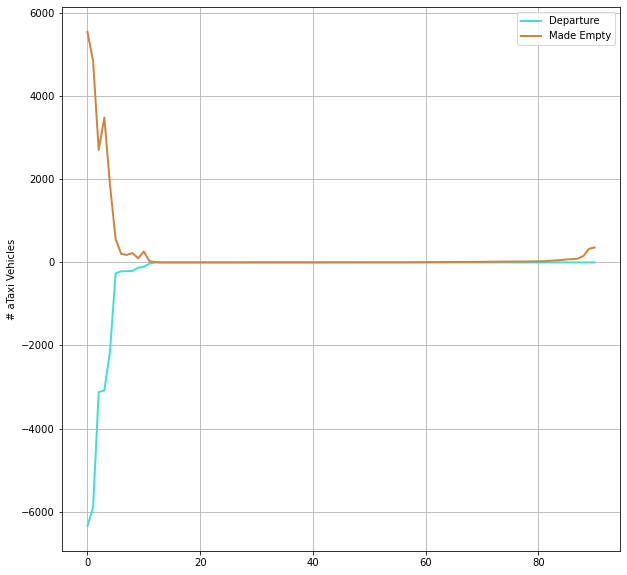

<IPython.core.display.Javascript object>

In [55]:
fig = plt.figure()
ax = plt.subplot(111)
sorted_super_pixel_vehicle_activity.plot(
    ax=ax,
    use_index=True,
    y="Sum aTaxi Vehicle Departures",
    grid=True,
    figsize=(10, 10),
    color="Turquoise",
    label="Departure",
    lw=2,
)
super_pixel_id_plot = sorted_super_pixel_vehicle_activity.plot(
    ax=ax,
    use_index=True,
    y="Sum aTaxi Vehicle Made Empty",
    grid=True,
    color="Peru",
    label="Made Empty",
    lw=2,
    ylabel="# aTaxi Vehicles",
)
super_pixel_id_plot.get_figure().savefig(
    "Outputs/aTaxiVehicleDepartures&aTaxiVehicleMadeEmptyv.SuperPixel#.png"
)

#### 3.a.i.a.e. Create a hashtable/hashfunction that allows you to type in **{xSuperPixel, ySuperPixel}** and it returns the SuperPixel \# (The row \# of the **SortedSummarySuperPixelVehicleActivity_Region{}** array)

In [56]:
# 2 dictionaries --> pixel to id, id to pixel


def make_dict(df):
    id2pix = {}
    pix2id = {}
    for i, row in df.iterrows():
        id2pix[i] = row["XSuper"], row["YSuper"]
        pix2id[row["XSuper"], row["YSuper"]] = i
    return id2pix, pix2id


id_to_pix, pix_to_id = make_dict(sorted_super_pixel_vehicle_activity)


def find_id(x, y):
    return pix_to_id.get((x, y))


def find_super_pixel(i):
    return id_to_pix.get(i)

<IPython.core.display.Javascript object>

In [57]:
find_super_pixel(6)

(-20.0, 21.0)

<IPython.core.display.Javascript object>

## 3.b. Repositioning throughout the Day.
### 3.b.i. Sort **SuperPixelVehicleTripOorD{}** by the last column, time to create **SortedByTimeSuperPixelVehicleTripOorD_Region{}**. This sorted file represents the changes is supply&demand at individual SuperPixels as time progresses throughout the day.

In [58]:
sorted_time_super_pixel_vehicle_trip = super_pixel_vehicle_trip.sort_values(
    by=["Time"]
).reset_index(drop=True)

sorted_time_super_pixel_vehicle_trip.head()

,Weight,XSuper,YSuper,Time
0,-1.0,-37,21,0.0
1,-1.0,-21,21,3.0
2,-1.0,-21,21,4.0
3,-1.0,-20,20,4.0
4,-1.0,-21,21,8.0


<IPython.core.display.Javascript object>

## Save Files

In [59]:
sorted_time_super_pixel_vehicle_trip.to_csv(
    "Outputs/SortedByTimeSuperPixelVehicleTripOorD_Region.csv"
)
sorted_time_super_pixel_vehicle_trip_temp = addLonLat(
    sorted_time_super_pixel_vehicle_trip, "XSuper", "YSuper", 3
)
sorted_time_super_pixel_vehicle_trip_izzy = addTime(
    sorted_time_super_pixel_vehicle_trip_temp
)

sorted_time_super_pixel_vehicle_trip_izzy.to_csv(
    "Outputs/SortedByTimeSuperPixelVehicleTripOorD_Region_Isabelle.csv"
)

<IPython.core.display.Javascript object>

### 3.b.ii.Start the day at 1 second after midnight with **StateOfVehicles@SuperPixel{}** = \# vehicles @ Midnight @ each SuperPixel from the end of Step 2 above. This is a (nx1) vector where n = number of SuperPixels in Region.

In [60]:
midnight_super_pixel = super_pixels_midnight.drop(["Weight"], axis=1)

midnight_super_pixel["0"] = vehicles_midnight
midnight_super_pixel = midnight_super_pixel.drop(["Vehicles @ Midnight"], axis=1)
midnight_super_pixel.head()

,XSuper,YSuper,0
0,-41,27,-1.0
1,-40,27,-1.0
2,-39,21,-1.0
3,-39,27,-1.0
4,-39,28,-1.0


<IPython.core.display.Javascript object>

### 3.b.iii. After an increment of time, which we will take as 10 minutes (600 seconds), the **StateOfVehicles@SuperPixel{} (t+(600-))** = number of aTaxiVehicles remaining at each SuperPixel Depot after 600 seconds have elapsed but before any instantaneous repositioning (\# started with - \# aTaxiVehicles departed (arrived?) in that time period + \# aTaxiVehicles departed in that time period) = **StateOfVehicles@SuperPixel{} (t+)** + Sum of first Column of **SortedByTimeSuperPixelVehicleTripOorD_Region{}** for that span of 600 seconds for each SuperPixel (which can be obtained by reading down the **SortedByTimeSuperPixelVehicleTripOorD_Region{}** file for the next 600 seconds. ) = **StateOfVehicles@SuperPixel{}(t+(600-))**

In [61]:
def find_state(group, time, next_time):
    return (
        ((group["Time"] >= time) & (group["Time"] < next_time)) * group["Weight"]
    ).sum()


def vehicle_state_functions(group):
    TENMIN = 144
    data = {}
    for i in range(TENMIN):
        time = i * 10 * 60  # time im currently looking at
        next_time = (i + 1) * 10 * 60 - 1
        data["" + str(next_time)] = find_state(
            group, time, next_time
        )  # count arrive/depart within this time
    return pd.Series(data)

<IPython.core.display.Javascript object>

In [62]:
arrive_depart_super_pixels = (
    sorted_time_super_pixel_vehicle_trip.groupby(["XSuper", "YSuper"])
    .apply(vehicle_state_functions)
    .reset_index()
)
arrive_depart_super_pixels.head()

,XSuper,YSuper,599,1199,1799,2399,2999,3599,4199,4799,...,80999,81599,82199,82799,83399,83999,84599,85199,85799,86399
0,-41,27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-40,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-39,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-39,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-39,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [63]:
merged = pd.merge(
    midnight_super_pixel, arrive_depart_super_pixels, on=["XSuper", "YSuper"]
)
state_of_vehicles_super_pixel = pd.concat(
    [
        merged[["XSuper", "YSuper"]],
        merged.drop(["XSuper", "YSuper"], axis=1).cumsum(axis=1),
    ],
    axis=1,
)

state_of_vehicles_super_pixel.head()

,XSuper,YSuper,0,599,1199,1799,2399,2999,3599,4199,...,80999,81599,82199,82799,83399,83999,84599,85199,85799,86399
0,-41,27,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,9.0,9.0,10.0,10.0,11.0,11.0,11.0,11.0,11.0,11.0
1,-40,27,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-39,21,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
3,-39,27,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-39,28,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

## Save Files

In [64]:
# State of Vehicles @ Super Pixel
state_of_vehicles_super_pixel.to_csv("Outputs/StateOfVehicles@SuperPixel.csv")
state_of_vehicles_super_pixel_izzy = addLonLat(
    state_of_vehicles_super_pixel, "XSuper", "YSuper", 3
)
state_of_vehicles_super_pixel_izzy.to_csv(
    "Outputs/StateOfVehicles@SuperPixel_Isabelle.csv"
)

<IPython.core.display.Javascript object>

### 3.b.iv At this point we want to determine how many aTaxiVehicles need to be dispatched empty from the SuperPixels that have a positive supply of aTaxiVehicles that will “instantaneously arrive” at the SuperPixels that have negative supply (net positive demand). So the the Transportation Problem that we wish to solve is the one that minimizes aTaxiVehicleMiles from a Supply Vector is made up of the positive values of **StateOfVehicles@SuperPixel{} (t+(600-))** and zeros for the negative values and a demand vector that has the absolute value of the negative values of the **StateOfVehicles@SuperPixel{} (t+(600-))** and zeros for the negative values **StateOfVehicles@SuperPixel{} (t+(600-))**. If as will usually be the case, the supply is greater than demand, then a “SuperSink” needs to be added to balance the demand (with costs from all SuperPixels to the SuperSink = 0). The costs between each SuperPixel is simply the Cartesian Distance. If Supply is less than Demand, then a Super Source needs to be added to create the balance and the cost from the Super Source to any SuperPixel is some very large number, say 1 million.
### 3.b.v. Solve the Transportation Problem for that instantaneous Time. And record the movements in the **EmptyMovementFile{}** which contains { \# of aTaxiVehicles,xEmptyFromSuperPixel, yEmptyFromSuperPixel, xEmptyToSuperPixel yEmptyToSuperPixel, Time}
### 3.b.vi. Update **StateOfVehicles@SuperPixel{} (t+(600+))** = **StateOfVehicles@SuperPixel{} (t+(600-))** + movements from **EmptyMovementFile{}(t+600)**.
### 3.b.vii. Loop on iii above until Midnight- is reached

In [65]:
def calc_distance_pix(ox, oy, dx, dy):
    return 0.5 * np.sqrt((dx - ox) ** 2 + (dy - oy) ** 2)


def update_cost(cost, ss):
    n = len(cost)
    for i in range(n):
        if ss < 0:
            cost[i][n - 1] = 1000000
            cost[n - 1][i] = 0
        elif ss > 0:
            cost[n - 1][i] = 1000000
            cost[i][n - 1] = 0
        else:
            cost[i][n - 1] = 1000000
            cost[n - 1][i] = 1000000


def get_base_cost(df):
    n = len(df) + 1
    d = np.zeros(shape=(n, n))
    for i in range(n - 1):
        ox, oy = find_super_pixel(i)
        for j in range(n - 1):
            dx, dy = find_super_pixel(j)
            d[i][j] = calc_distance_pix(ox, oy, dx, dy)
    return d


# wrote a function that computes cost, and then feed into this method
def get_supply_demand(df, time):
    data = df.copy().set_index(["XSuper", "YSuper"])
    source_sink = data[time].sum()
    n = len(data) + 1
    supply_demand = []
    for i in range(n):
        if source_sink != 0 and i == (n - 1):
            weight = -source_sink
        else:
            ox, oy = find_super_pixel(i)
            weight = data.loc[(ox, oy), time]
        supply_demand.append(weight)
    return np.array(supply_demand), source_sink

<IPython.core.display.Javascript object>

In [66]:
# run transportation problem
def transportation_problem(cost, sd):
    X = cp.Variable(cost.shape, integer=True)  # = False, round the answers
    prob = cp.Problem(
        cp.Minimize(cp.sum(cp.multiply(cost, X))),
        [cp.sum(X, axis=1) - cp.sum(X, axis=0) == sd, X >= 0, cp.trace(X) == 0],
    )
    prob.solve(verbose=True)
    return X.value


# print("status:", prob.status)
# print("objective:", prob.value)
# print("levels:", X.value)

<IPython.core.display.Javascript object>

In [67]:
def create_empty_movement(df):
    start_file = pd.DataFrame(
        columns=[
            "# of aTaxi Vehicles",
            "xEmptyFrom",
            "yEmptyFrom",
            "xEmptyTo",
            "yEmptyTo",
            "Time",
            "aTaxi Vehicle Miles",
        ]
    )

    cost = get_base_cost(df)
    count = 0
    for name, col in df.iteritems():
        if name == "XSuper" or name == "YSuper" or name == "0":
            continue
        else:
            # set up data
            super_pix = df[["XSuper", "YSuper"]].copy()
            super_pix[name] = col
            supply_demand, ss = get_supply_demand(super_pix, name)
            update_cost(cost, ss)
            # cost, supply_demand = get_variables(super_pix, name)
            X = transportation_problem(cost, supply_demand)
            # print(count)
            for i in range(len(df)):
                ox, oy = find_super_pixel(i)
                for j in range(len(df)):
                    dx, dy = find_super_pixel(j)
                    if X[i][j] != 0:
                        start_file = start_file.append(
                            {
                                "# of aTaxi Vehicles": X[i][j],
                                "xEmptyFrom": ox,
                                "yEmptyFrom": oy,
                                "xEmptyTo": dx,
                                "yEmptyTo": dy,
                                "Time": name,
                                "aTaxi Vehicle Miles": cost[i][j],
                            },
                            ignore_index=True,
                        )
        count += 1
        if count % 20 == 0:
            print("status:", count, "/", len(df.columns))
    return start_file

<IPython.core.display.Javascript object>

In [68]:
%lprun -f create_empty_movement create_empty_movement(state_of_vehicles_super_pixel[['XSuper', "YSuper", "599"]])

<IPython.core.display.Javascript object>

In [69]:
empty_movement_file = create_empty_movement(state_of_vehicles_super_pixel)
empty_movement_file.head()

status: 20 / 147
status: 40 / 147
status: 60 / 147
status: 80 / 147
status: 100 / 147
status: 120 / 147
status: 140 / 147


,# of aTaxi Vehicles,xEmptyFrom,yEmptyFrom,xEmptyTo,yEmptyTo,Time,aTaxi Vehicle Miles
0,1.0,-21.0,21.0,-25.0,24.0,599,2.500000
1,1.0,-21.0,21.0,-22.0,22.0,599,0.707107
2,1.0,-21.0,21.0,-25.0,23.0,599,2.236068
3,1.0,-21.0,21.0,-23.0,21.0,599,1.000000
4,1.0,-21.0,21.0,-25.0,22.0,599,2.061553


<IPython.core.display.Javascript object>

## Save Files

In [70]:
# Empty Movement File
# change type of dataframe elements
empty_movement_file["xEmptyFrom"] = empty_movement_file["xEmptyFrom"].astype(int)
empty_movement_file["yEmptyFrom"] = empty_movement_file["yEmptyFrom"].astype(int)
empty_movement_file["xEmptyTo"] = empty_movement_file["xEmptyTo"].astype(int)
empty_movement_file["yEmptyTo"] = empty_movement_file["yEmptyTo"].astype(int)
empty_movement_file.to_csv("Outputs/EmptyMovementFile.csv")
empty_movement_file_temp1 = addLonLat(
    empty_movement_file, "xEmptyFrom", "yEmptyFrom", 4
)
empty_movement_file_temp2 = addLonLat(
    empty_movement_file_temp1, "xEmptyTo", "yEmptyTo", 5
)
empty_movement_file_izzy = addTime(empty_movement_file_temp2)
empty_movement_file_izzy.to_csv("Outputs/EmptyMovementFile_Isabelle.csv")

<IPython.core.display.Javascript object>

In [71]:
empty_movement_file_izzy.head()

,# of aTaxi Vehicles,xEmptyFrom,yEmptyFrom,xEmptyTo,yEmptyTo,Time,aTaxi Vehicle Miles,oLat,oLon,dLat,dLon,Hour
0,1.0,-21,21,-25,24,599,2.500000,44.593161,-108.152757,45.677382,-110.426277,00:09:59
1,1.0,-21,21,-22,22,599,0.707107,44.593161,-108.152757,44.954568,-108.730335,00:09:59
2,1.0,-21,21,-25,23,599,2.236068,44.593161,-108.152757,45.315975,-110.343581,00:09:59
3,1.0,-21,21,-23,21,599,1.000000,44.593161,-108.152757,44.593161,-109.167788,00:09:59
4,1.0,-21,21,-25,22,599,2.061553,44.593161,-108.152757,44.954568,-110.262440,00:09:59


<IPython.core.display.Javascript object>

In [72]:
def update_state_of_vehicles(df, update):
    data = df.copy().set_index(["XSuper", "YSuper"])
    for i, row in update.iterrows():
        time = row["Time"]
        vehicles_moved = row["# of aTaxi Vehicles"]
        ox = row["xEmptyFrom"]
        oy = row["yEmptyFrom"]
        dx = row["xEmptyTo"]
        dy = row["yEmptyTo"]
        data.at[(ox, oy), time] = data.loc[(ox, oy), time] - vehicles_moved
        data.at[(dx, dy), time] = data.loc[(dx, dy), time] + vehicles_moved
    return data.reset_index()

<IPython.core.display.Javascript object>

In [73]:
update_state_of_vehicles_super_pixel = update_state_of_vehicles(
    state_of_vehicles_super_pixel, empty_movement_file
)

update_state_of_vehicles_super_pixel.head()

,XSuper,YSuper,0,599,1199,1799,2399,2999,3599,4199,...,80999,81599,82199,82799,83399,83999,84599,85199,85799,86399
0,-41,27,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,9.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0
1,-40,27,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-39,21,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
3,-39,27,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-39,28,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

## Save Files

In [74]:
update_state_of_vehicles_super_pixel.to_csv(
    "Outputs/UpdatedStateOfVehicles@SuperPixel.csv"
)

update_state_of_vehicles_super_pixel_izzy = addLonLat(
    update_state_of_vehicles_super_pixel, "XSuper", "YSuper", 3
)
update_state_of_vehicles_super_pixel_izzy.to_csv(
    "Outputs/UpdatedStateOfVehicles@SuperPixel_Isabelle.csv"
)

<IPython.core.display.Javascript object>

### 3.b.viii. Once at Midnight- Determine the Instantaneous Empty Repositioning needed to **StateOfVehicles@SuperPixel{}** = \# vehicles @ Midnight @ each SuperPixel from the end of Step 2 above.


#### 3.b.viii.1. Add those empty movements to complete the **EmptyMovementFile{}** Summarize that file by [ASK ABOUT THIS!]
##### 3.b.viii.1.a. Plot \# of empty aTaxiVehicles repositioned v. Time of Day
##### 3.b.viii.1.b. Plot Average empty aTaxiVehiclesMiles repositioned v Time of Day

In [75]:
def update_empty_movement(df, update):
    time = "0"
    data = df.copy()
    cost = get_base_cost(update)
    weights = update.iloc[:, 0] - update.iloc[:, -1]
    super_pix = update[["XSuper", "YSuper"]].copy()
    super_pix["0"] = weights
    supply_demand, ss = get_supply_demand(super_pix, time)
    update_cost(cost, ss)
    X = transportation_problem(cost, supply_demand)
    for i in range(len(update)):
        ox, oy = find_super_pixel(i)
        for j in range(len(update)):
            dx, dy = find_super_pixel(j)
            if X[i][j] != 0:
                data = data.append(
                    {
                        "# of aTaxi Vehicles": X[i][j],
                        "xEmptyFrom": ox,
                        "yEmptyFrom": oy,
                        "xEmptyTo": dx,
                        "yEmptyTo": dy,
                        "Time": time,
                        "aTaxi Vehicle Miles": cost[i][j],
                    },
                    ignore_index=True,
                )
    return data

<IPython.core.display.Javascript object>

In [76]:
def find_num_repositioned(group):
    return group["# of aTaxi Vehicles"].sum()


def find_avg_miles_repositioned(group):
    return group["aTaxi Vehicle Miles"].mean()


def find_tot_miles_repositioned(group):
    return group["aTaxi Vehicle Miles"].sum()


def empty_functions(group):
    data = {}
    data["# of aTaxi Repositioned"] = find_num_repositioned(group)
    data["Total aTaxi Miles Repositioned"] = find_tot_miles_repositioned(group)
    data["Average aTaxi Miles Repositioned"] = find_avg_miles_repositioned(group)
    return pd.Series(data)

<IPython.core.display.Javascript object>

In [77]:
update_empty_movement_file = update_empty_movement(
    empty_movement_file, update_state_of_vehicles_super_pixel
)
update_empty_movement_file = addTime(update_empty_movement_file)
ataxi_repositioned = (
    update_empty_movement_file.groupby("Hour").apply(empty_functions).reset_index()
)

<IPython.core.display.Javascript object>

In [78]:
update_empty_movement_file.head()

,# of aTaxi Vehicles,xEmptyFrom,yEmptyFrom,xEmptyTo,yEmptyTo,Time,aTaxi Vehicle Miles,Hour
0,1.0,-21,21,-25,24,599,2.500000,00:09:59
1,1.0,-21,21,-22,22,599,0.707107,00:09:59
2,1.0,-21,21,-25,23,599,2.236068,00:09:59
3,1.0,-21,21,-23,21,599,1.000000,00:09:59
4,1.0,-21,21,-25,22,599,2.061553,00:09:59


<IPython.core.display.Javascript object>

## Save Files

In [79]:
update_empty_movement_file["xEmptyFrom"] = update_empty_movement_file[
    "xEmptyFrom"
].astype(int)
update_empty_movement_file["yEmptyFrom"] = update_empty_movement_file[
    "yEmptyFrom"
].astype(int)
update_empty_movement_file["xEmptyTo"] = update_empty_movement_file["xEmptyTo"].astype(
    int
)
update_empty_movement_file["yEmptyTo"] = update_empty_movement_file["yEmptyTo"].astype(
    int
)

update_empty_movement_file.to_csv("Outputs/UpdatedEmptyMovementFile.csv")
update_empty_movement_file_temp1 = addLonLat(
    update_empty_movement_file, "xEmptyFrom", "yEmptyFrom", 4
)
update_empty_movement_file_temp2 = addLonLat(
    update_empty_movement_file_temp1, "xEmptyFrom", "yEmptyFrom", 5
)
update_empty_movement_file_izzy = addTime(update_empty_movement_file_temp2)
update_empty_movement_file_izzy.to_csv("Outputs/UpdatedEmptyMovementFile_Isabelle.csv")

<IPython.core.display.Javascript object>

In [80]:
# ataxi_repositioned["Time"] = ataxi_repositioned["Time"].astype(int)
ataxi_repositioned = ataxi_repositioned.sort_values(
    by=["Hour"], ascending=True
).reset_index(drop=True)

<IPython.core.display.Javascript object>

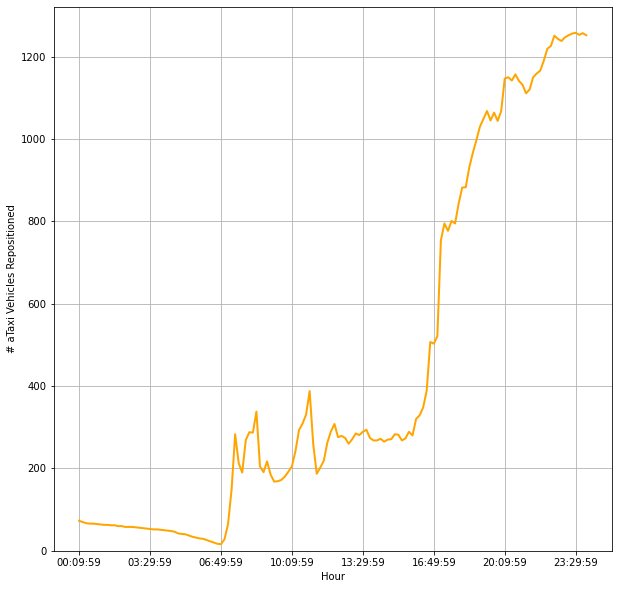

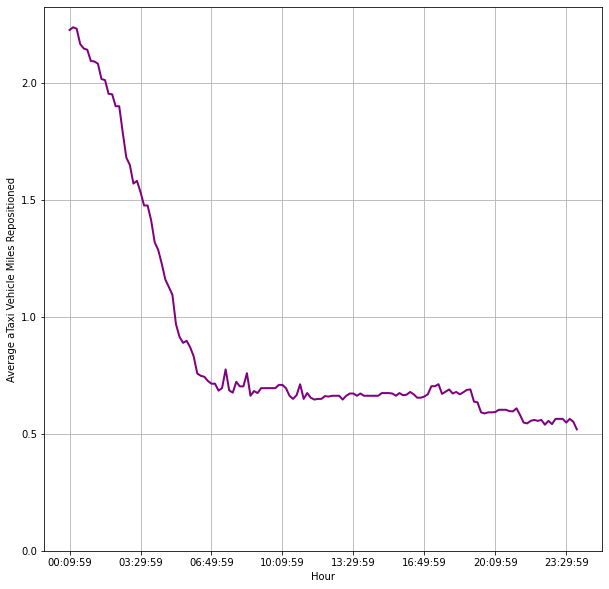

<IPython.core.display.Javascript object>

In [81]:
# plot # of empty aTaxiVehicles repositioned v. Time of Day
num_empty_aTaxi_repositioned_plt = ataxi_repositioned.plot(
    x="Hour",
    y="# of aTaxi Repositioned",
    color="Orange",
    grid=True,
    lw=2,
    figsize=(10, 10),
    ylabel="# aTaxi Vehicles Repositioned",
    legend=None,
)
num_empty_aTaxi_repositioned_plt.set_ylim(ymin=0)
num_empty_aTaxi_repositioned_plt.get_figure().savefig(
    "Outputs/#aTaxiVehiclesRespositionedv.TOD.png"
)

# plot average empty aTaxiVehiclesMiles repositioned v Time of Day
avg_aTaxi_vehicle_miles_repositioned_plt = ataxi_repositioned.plot(
    x="Hour",
    y="Average aTaxi Miles Repositioned",
    color="Purple",
    grid=True,
    lw=2,
    figsize=(10, 10),
    ylabel="Average aTaxi Vehicle Miles Repositioned",
    legend=None,
)
avg_aTaxi_vehicle_miles_repositioned_plt.set_ylim(ymin=0)
avg_aTaxi_vehicle_miles_repositioned_plt.get_figure().savefig(
    "Outputs/AverageaTaxiVehicleMilesRepositionedv.TOD.png"
)

#### 3.b.viii.2. Average number of times vehicle is repositioned during day = total \# Empty Vehicle Repositioning / FleetSize [REGION FLEET SIZE?]

In [82]:
total_num_aTaxi_repositioned = ataxi_repositioned["# of aTaxi Repositioned"].sum()
avg_num_aTaxi_repositioned = total_num_aTaxi_repositioned / region_fleet_size
print(
    "average number of times vehicle is repositioned during day:",
    avg_num_aTaxi_repositioned,
)

average number of times vehicle is repositioned during day: 43.61517429938482


<IPython.core.display.Javascript object>

#### 3.b.viii.3. Average repositioning distance

In [83]:
weighted_sum_repositioned_distance = (
    ataxi_repositioned["Average aTaxi Miles Repositioned"]
    * ataxi_repositioned["# of aTaxi Repositioned"]
).sum()
avg_repositioned_distance = (
    weighted_sum_repositioned_distance / total_num_aTaxi_repositioned
)

print("average repositioning distance:", avg_repositioned_distance)

average repositioning distance: 0.6520618481092925


<IPython.core.display.Javascript object>

#### 3.b.viii.4. CDF of repositioning distance throughout the Day

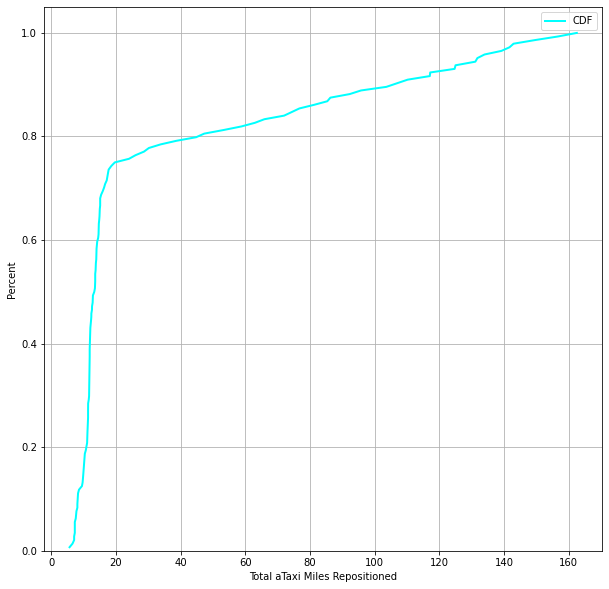

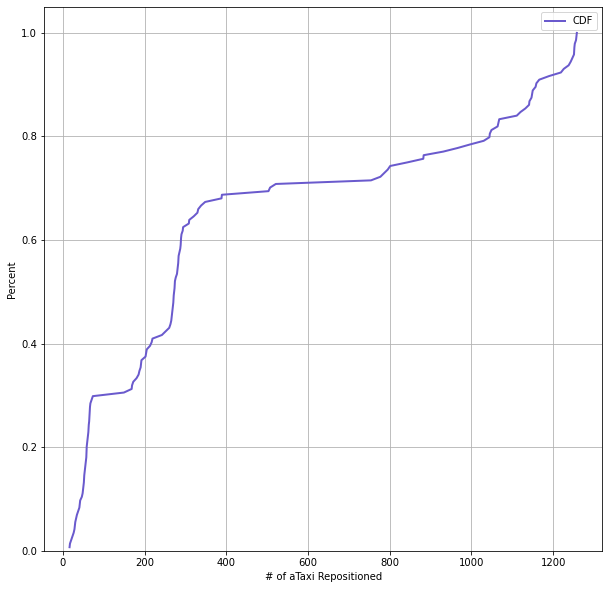

<IPython.core.display.Javascript object>

In [84]:
cdf_repositioned_distance = generate_cdf(
    ataxi_repositioned, "Total aTaxi Miles Repositioned"
)

cdf_repositioned_vehicles = generate_cdf(ataxi_repositioned, "# of aTaxi Repositioned")

cdf_repositioned_distance_plt = cdf_repositioned_distance.plot(
    x="Total aTaxi Miles Repositioned",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="Cyan",
    lw=2,
    ylabel="Percent",
)
cdf_repositioned_distance_plt.set_ylim(ymin=0)
cdf_repositioned_distance_plt.get_figure().savefig(
    "Outputs/cdf_repositioned_distance_plt.png"
)

cdf_repositioned_vehicles_plt = cdf_repositioned_vehicles.plot(
    x="# of aTaxi Repositioned",
    y="CDF",
    grid=True,
    figsize=(10, 10),
    color="SlateBlue",
    lw=2,
    ylabel="Percent",
)
cdf_repositioned_vehicles_plt.set_ylim(ymin=0)
cdf_repositioned_vehicles_plt.get_figure().savefig(
    "Outputs/cdf_repositioned_vehicles_plt.png"
)